In [1]:
import numpy as np
import math
import random 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabaz_score
from scipy.spatial import distance

In [2]:
class Point:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __str__(self):
        return str(self.__dict__)

    def __eq__(self, other): 
        return self.__dict__ == other.__dict__

    def __hash__(self):
        return hash((self.x, self.y))

    def __ne__(self, other):
        # Not strictly necessary, but to avoid having both x==y and x!=y
        # True at the same time
        return not(self == other)
    
    def distance_measure(self,pnt):
        return distance.euclidean([self.x,self.y],[pnt.x,pnt.y])
        #return math.hypot(self.x - pnt.x, self.y - pnt.y)
    
    def epsilon_neighbourhood(self, pnt, eps_dist):
        return distance.euclidean([self.x,self.y],[pnt.x,pnt.y]) <= eps_dist
        #return math.hypot(self.x - pnt.x, self.y - pnt.y) < eps_dist

    def print_point(self):
        print(self.__dict__)

In [3]:
def read_input(input_file):
    points = []    
    labels = []
    with open(input_file, "r") as ins:
        for line in ins:
            tokens = line.split();
            pnt = Point(float(tokens[0]),float(tokens[1]))
            if len(tokens) == 3:
                labels.append(tokens[2])
            points.append(pnt)
    return(points,labels)

# DB-Scan

In [4]:
def cluster_evaluation(result,labels,str,points):
    try:
        matrix = list(map(lambda l: [l.x,l.y],points))
        result_algo = list(result)
        labels_given = list(labels)

        # DELETE THE NOISE POINTS
        for i,val in enumerate(result_algo):
            if val == 0:
                del matrix[i]
                del result_algo[i]
                del labels_given[i]

        nmi = normalized_mutual_info_score(result_algo, labels_given)
        sc = silhouette_score(matrix,result_algo)
        ch = calinski_harabaz_score(matrix,result_algo)
    except:
        return(nmi,'Empty Cluster: N/A','Empty Cluster: N/A')
    
    return(nmi,sc,ch)

In [5]:
import matplotlib.cm as cm
from random import randint

colors = ['sienna','red','springgreen','darkmagenta','aqua','crimson','green','pink','yellow','maroon','Golden',]
markers = ['H','+','^','s','o','x','<','|','+','h','d']

def plot_scatter_dbscan(points,cluster_labels,number_of_clusters,nmi,sc,ch,output,actual_labels):
    print('')
    print('Plotting for the Best Result ')
    print('Note: Noise Points are colored Black')
    x = list(map(lambda l: l.x,points))
    y = list(map(lambda l: l.y,points))
    colormap = plt.cm.gist_ncar  
    colorst = [colormap(i) for i in np.linspace(0, 1.0,number_of_clusters+1)]   
    for i,val in enumerate(cluster_labels):
        if val != 0:
            plt.scatter([x[i]], [y[i]],c=colors[val%10],alpha=1,marker=markers[int(actual_labels[i])],s=70)
        else:
            plt.scatter([x[i]], [y[i]],c='black',alpha=1,s=50,marker=markers[int(actual_labels[i])])
    plt.show()
    
    print(output)
    print('NMI:\t',nmi)
    print('SC:\t',sc)
    print('CH:\t',ch)
    print('=======================================')


def expand_cluster(point_pos,cluster_label,min_points,eps_dist,cluster_labels,points):
    
    neighbourhood = region_inquiry(points[point_pos],eps_dist,points)
    
    if len(neighbourhood) < min_points:
        cluster_labels[point_pos] = 0
        return False
    else:
        cluster_labels[point_pos] = cluster_label
        
        for pos in neighbourhood:
            cluster_labels[pos] = cluster_label
        
        while len(neighbourhood) > 0:
            point_neighbourhood = region_inquiry(points[neighbourhood[0]],eps_dist,points)
            
            if len(point_neighbourhood) >= min_points:
                for i,result_point in enumerate(point_neighbourhood):
                      if cluster_labels[result_point] == False or cluster_labels[result_point] == 0:
                            neighbourhood.append(result_point)
                            cluster_labels[result_point] = cluster_label
            neighbourhood.pop(0)
        
        return True

In [6]:
def region_inquiry(pnt,eps_dist,points):
    neighbourhood = []
    for i,val in enumerate(points):
        if pnt.epsilon_neighbourhood(val,eps_dist):
            neighbourhood.append(i)
        i+=1  
    return neighbourhood    
                
def db_scan(points,eps_dist,min_points):
    number_of_points = len(points)
    cluster_labels = [False] * number_of_points
    cluster_id = 1
    for point_id in range(0, number_of_points):
        point = points[point_id]
        if cluster_labels[point_id] == False:
            if expand_cluster(point_id, cluster_id,min_points,eps_dist,cluster_labels,points):
                cluster_id = cluster_id + 1
    return(cluster_labels)

In [7]:
def run_for_dataset(eps,minpoints,dataset,labels,dataset_name):
    results = []
    for i,ep in enumerate(eps):
        for j,minp in enumerate(minpoints):
            db_scan_labels = db_scan(dataset,ep,minp)
            output = 'Evaluation for Dataset {}, Eps ∈ {}, MinPts ∈ {}'
            nmi, sc, ch = cluster_evaluation(db_scan_labels,labels,output.format(dataset_name,ep,minp),dataset)
            print(output.format(dataset_name,ep,minp))
            print('NMI:\t',nmi)
            print('SC:\t',sc)
            print('CH:\t',ch)
            print('=======================================')
            results.append([output.format(dataset_name,ep,minp),db_scan_labels,nmi,sc,ch])
    
    return results      

# DATASET 1 EVALUATION AND BEST RESULT PLOT
### Note: Noise Points are black

In [8]:
points_1,labels_1 = read_input("dataset1.txt")
results_dataset1 = run_for_dataset([0.2, 0.3, 0.4],[2, 3, 4],points_1,labels_1,"1")

Evaluation for Dataset 1, Eps ∈ 0.2, MinPts ∈ 2
NMI:	 0.774689914894
SC:	 0.378498926145
CH:	 278.063740429
Evaluation for Dataset 1, Eps ∈ 0.2, MinPts ∈ 3
NMI:	 0.785508310791
SC:	 0.461070447575
CH:	 259.442652308
Evaluation for Dataset 1, Eps ∈ 0.2, MinPts ∈ 4
NMI:	 0.762288690776
SC:	 0.428398768838
CH:	 153.44756456
Evaluation for Dataset 1, Eps ∈ 0.3, MinPts ∈ 2
NMI:	 0.883859302228
SC:	 0.422361649655
CH:	 223.381972422
Evaluation for Dataset 1, Eps ∈ 0.3, MinPts ∈ 3
NMI:	 0.933228097054
SC:	 0.536902369089
CH:	 318.453748941
Evaluation for Dataset 1, Eps ∈ 0.3, MinPts ∈ 4
NMI:	 0.963948650823
SC:	 0.678184877653
CH:	 408.131088467
Evaluation for Dataset 1, Eps ∈ 0.4, MinPts ∈ 2
NMI:	 0.975092015524
SC:	 0.626529611757
CH:	 445.759824082
Evaluation for Dataset 1, Eps ∈ 0.4, MinPts ∈ 3
NMI:	 1.0
SC:	 0.735887453815
CH:	 646.432429643
Evaluation for Dataset 1, Eps ∈ 0.4, MinPts ∈ 4
NMI:	 1.0
SC:	 0.737772089744
CH:	 655.625678



Plotting for the Best Result 
Note: Noise Points are colored Black


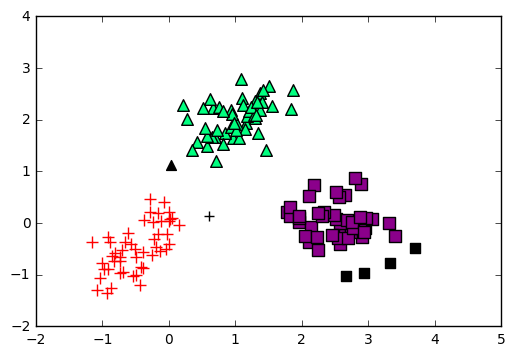

Evaluation for Dataset 1, Eps ∈ 0.4, MinPts ∈ 4
NMI:	 1.0
SC:	 0.737772089744
CH:	 655.625678


In [9]:
best_dataset_1 = results_dataset1[8]
plot_scatter_dbscan(points_1,best_dataset_1[1],max(best_dataset_1[1])+1,best_dataset_1[2],best_dataset_1[3],best_dataset_1[4],best_dataset_1[0],labels_1)


# DATASET 2 Evaluation and Best Result Plot
### Note: Noise Points are Black

In [10]:
points_2,labels_2 = read_input("dataset2.txt")
results_dataset2 = run_for_dataset([0.8, 0.85, 0.9],[6, 7, 8],points_2,labels_2,"2")

Evaluation for Dataset 2, Eps ∈ 0.8, MinPts ∈ 6
NMI:	 1.0
SC:	 0.655186948696
CH:	 442.188216731
Evaluation for Dataset 2, Eps ∈ 0.8, MinPts ∈ 7
NMI:	 0.986428679301
SC:	 0.507810683293
CH:	 350.448410963
Evaluation for Dataset 2, Eps ∈ 0.8, MinPts ∈ 8
NMI:	 0.976579401129
SC:	 0.545986598602
CH:	 359.531754765
Evaluation for Dataset 2, Eps ∈ 0.85, MinPts ∈ 6
NMI:	 1.0
SC:	 0.647110728283
CH:	 423.419608032
Evaluation for Dataset 2, Eps ∈ 0.85, MinPts ∈ 7
NMI:	 0.986452573544
SC:	 0.504738030723
CH:	 341.6316581
Evaluation for Dataset 2, Eps ∈ 0.85, MinPts ∈ 8
NMI:	 0.986404505142
SC:	 0.509291807193
CH:	 349.57886301
Evaluation for Dataset 2, Eps ∈ 0.9, MinPts ∈ 6
NMI:	 1.0
SC:	 0.639553233305
CH:	 406.62053703
Evaluation for Dataset 2, Eps ∈ 0.9, MinPts ∈ 7
NMI:	 1.0
SC:	 0.641580403992
CH:	 412.162695133
Evaluation for Dataset 2, Eps ∈ 0.9, MinPts ∈ 8
NMI:	 1.0
SC:	 0.650223036141
CH:	 434.969752038



Plotting for the Best Result 
Note: Noise Points are colored Black


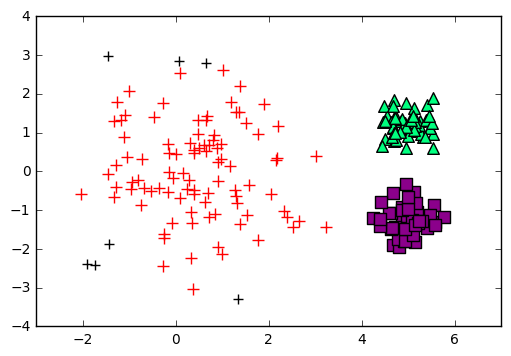

Evaluation for Dataset 2, Eps ∈ 0.9, MinPts ∈ 6
NMI:	 1.0
SC:	 0.639553233305
CH:	 406.62053703


In [11]:
best_dataset_2 = results_dataset2[6]
plot_scatter_dbscan(points_2,best_dataset_2[1],max(best_dataset_2[1])+1,best_dataset_2[2],best_dataset_2[3],best_dataset_2[4],best_dataset_2[0],labels_2)


# DATASET 3 Evaluation and Best Result Plot
### Note: Noise Points are Black

In [12]:
points_3,labels_3 = read_input("dataset3.txt")
results_dataset3 = run_for_dataset([0.2, 0.3, 0.4],[5, 6, 7],points_3,labels_3,"3")

Evaluation for Dataset 3, Eps ∈ 0.2, MinPts ∈ 5
NMI:	 0.817268744348
SC:	 0.376957514331
CH:	 184.086375135
Evaluation for Dataset 3, Eps ∈ 0.2, MinPts ∈ 6
NMI:	 0.820645669849
SC:	 0.377235994282
CH:	 175.307652116
Evaluation for Dataset 3, Eps ∈ 0.2, MinPts ∈ 7
NMI:	 0.820645669849
SC:	 0.377235994282
CH:	 175.307652116
Evaluation for Dataset 3, Eps ∈ 0.3, MinPts ∈ 5
NMI:	 1.0
SC:	 0.362298541786
CH:	 162.813208069
Evaluation for Dataset 3, Eps ∈ 0.3, MinPts ∈ 6
NMI:	 1.0
SC:	 0.362298541786
CH:	 162.813208069
Evaluation for Dataset 3, Eps ∈ 0.3, MinPts ∈ 7
NMI:	 1.0
SC:	 0.362298541786
CH:	 162.813208069
Evaluation for Dataset 3, Eps ∈ 0.4, MinPts ∈ 5
NMI:	 8.881784197e-06
SC:	 Empty Cluster: N/A
CH:	 Empty Cluster: N/A
Evaluation for Dataset 3, Eps ∈ 0.4, MinPts ∈ 6
NMI:	 8.881784197e-06
SC:	 Empty Cluster: N/A
CH:	 Empty Cluster: N/A
Evaluation for Dataset 3, Eps ∈ 0.4, MinPts ∈ 7
NMI:	 8.881784197e-06
SC:	 Empty Cluster: N/A
CH:	 Empty Cluster: N/A



Plotting for the Best Result 
Note: Noise Points are colored Black


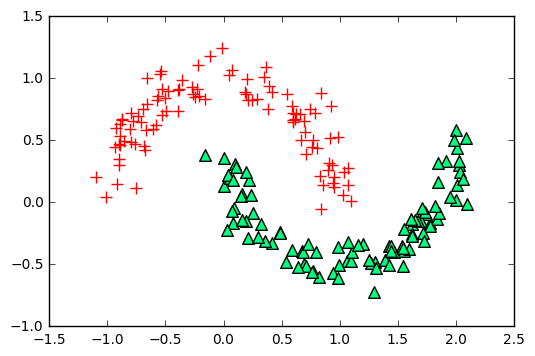

Evaluation for Dataset 3, Eps ∈ 0.3, MinPts ∈ 7
NMI:	 1.0
SC:	 0.362298541786
CH:	 162.813208069


In [13]:
best_val_3 = results_dataset3[5]
plot_scatter_dbscan(points_3,best_val_3[1],max(best_val_3[1])+1,best_val_3[2],best_val_3[3],best_val_3[4],best_val_3[0],labels_3)


# K-MEANS

In [14]:
def recalculate_centers(clusters,prev_centers):
    new_centers = []
    for k in sorted(clusters.keys()):
        y_mean = np.mean(list(map(lambda l: l.y,clusters[k])), axis = 0)
        x_mean = np.mean(list(map(lambda l: l.x,clusters[k])), axis = 0)
        
        if math.isnan(y_mean) and math.isnan(x_mean):
            new_centers.append(prev_centers[k])
        else:
            new_centers.append(Point(x_mean,y_mean))
    return new_centers

def check_convergence(prev_centers,new_centers):
    for i,val in enumerate(prev_centers):
        if val != new_centers[i]:
            return False
    return True
    
def assign_clusters(X,centers):
    clusters = {}
    for point in X:
        min_cent = point.distance_measure(centers[0])
        new_cent = 0
        for index,cen_point in enumerate(centers):
                if point.distance_measure(cen_point) < min_cent:
                    new_cent = index
                    min_cent = point.distance_measure(cen_point)
        
        if new_cent in clusters.keys():
            clusters[new_cent].append(point)
        else:
            clusters[new_cent] = [point]
    return clusters

def label_points(centers,clusters,points):
    point_labels = {}
    for key in clusters.keys():
        for point in clusters[key]:
            point_labels[point] = key
    
    labels = []
    for i,point in enumerate(points):
        labels.append(point_labels[point])
    
    return labels

def kmeans_start(X,K,initialize_means = None):
    prev_centers = []
    new_centers = []
    if initialize_means is None:
        prev_centers = random.sample(X,K);
        new_centers = random.sample(X,K);
    else:
        prev_centers = random.sample(X,K);
        new_centers = initialize_means
    
    while not check_convergence(prev_centers,new_centers):
        prev_centers = new_centers
        clusters = assign_clusters(X, prev_centers)
        new_centers = recalculate_centers(clusters,prev_centers)
    return (new_centers,clusters) 

def sum_of_squared_error(centers,clusters,k):
    sse = []
    for i,mean in enumerate(centers):
        if len(clusters[i]) == 0:
            sse[i] = 0
        else: 
            x = 0
            for j,pnt in enumerate(clusters[i]):
                x += pnt.distance_measure(mean)**2
            sse.append(x)
    return sum(sse)


In [15]:
import sys
def KMeans_helper(X,K,dataset_name,initial_means = None,iterations = 300):
    KMEANS_RESULTS = []
    SSE = []
    points,labels = read_input(X)
    means = None
    if initial_means is not None:
        means,l = read_input(X)
    output = 'Evaluation for Dataset {}, k = {}'
    for i in range(iterations):
            centers, clusters = kmeans_start(points,K,means)
            sse_val = sum_of_squared_error(centers,clusters,K)
            matrix = list(map(lambda l: [l.x,l.y],points))
            result_algo = list(label_points(centers,clusters,points))
            labels_given = list(labels)
            nmi = normalized_mutual_info_score(result_algo, labels_given)
            sc = silhouette_score(matrix,result_algo)
            ch = calinski_harabaz_score(matrix,result_algo)
            SSE.append(sse_val)
            KMEANS_RESULTS.append((sse_val,centers,clusters,nmi,sc,ch,output.format(dataset_name,K)))
    return (KMEANS_RESULTS,SSE,labels)

In [16]:
markers = ['H','D','^','s','o','x','<','|','+','h','d']
colors = ['aqua','red','springgreen','yellow','sienna','crimson','green','pink','yellow','maroon','Golden',]
def plot_scatter_kmeans(points,centers_v,clusters_v,nmi,sc,ch,sse_val,orignal_labels,output):
    print(output)
    print('SSE:\t',sse_val)
    print('NMI:\t',nmi)
    print('SC:\t',sc)
    print('CH:\t',ch)
    print('') 
    
    caculated_point_labels = {}
    for key in clusters_v.keys():
        for point in clusters_v[key]:
            caculated_point_labels[point] = key
    
    # Plot the points
    for i,p in enumerate(points):
        plt.scatter(points[i].x, points[i].y,c=colors[caculated_point_labels[p]],alpha=0.8,marker=markers[int(orignal_labels[i])],s=40)   
    
     # Plot the centers
    for key in clusters_v.keys():
        plt.scatter(centers_v[key].x, centers_v[key].y,c='black',alpha=1,marker='*',s=100)
    
    plt.show()
    
    print('=======================================')

In [17]:
# Main KMeans Funtion
# Call this with following parameters 
# dataset_name for ex: 'dataset1.txt'
# initial_means with (1*k matrix) where K is no. of clusters, or with None 
def KMeans (dataset_name,array_of_k,initial_means = None):
    sc_dataset_1 = []
    ch_dataset_1 = []
    nmi_dataset_1 = []
    sse_dataset_1 = []
    for k in array_of_k:
        K_MEANS_DATASET_1,SSE_DATASET_1,True_Labels_1 = KMeans_helper(dataset_name,k,dataset_name,initial_means)
        points_dataset1,labels = read_input(dataset_name)

        final_result = K_MEANS_DATASET_1[SSE_DATASET_1.index(min(SSE_DATASET_1))]

        centers_results = final_result[1]
        clusters_results = final_result[2]
        nmi_result = final_result[3]
        sc_result = final_result[4]
        ch_result = final_result[5]
        op = final_result[6]
        sse_result = min(SSE_DATASET_1)
        plot_scatter_kmeans(points_dataset1,centers_results,clusters_results,nmi_result,sc_result,ch_result,sse_result,True_Labels_1,op);

        sc_dataset_1.append(sc_result)
        nmi_dataset_1.append(nmi_result)
        ch_dataset_1.append(ch_result)
        sse_dataset_1.append(sse_result)

    print('SSE for Dataset: ',dataset_name)
    plt.plot(array_of_k,sse_dataset_1)
    plt.show()
    print('NMI for Dataset: ',dataset_name)
    plt.plot(array_of_k,nmi_dataset_1)
    plt.show()
    print('SC for Dataset: ', dataset_name)
    plt.plot(array_of_k,sc_dataset_1)
    plt.show()
    print('CH for Dataset: ',dataset_name)
    plt.plot(array_of_k,ch_dataset_1)
    plt.show()

# KMeans for Dataset 1
### Center of each cluster is Black star

Evaluation for Dataset dataset1.txt, k = 2
SSE:	 215.94349946135657
NMI:	 0.724927165677
SC:	 0.533082878752
CH:	 163.903539309



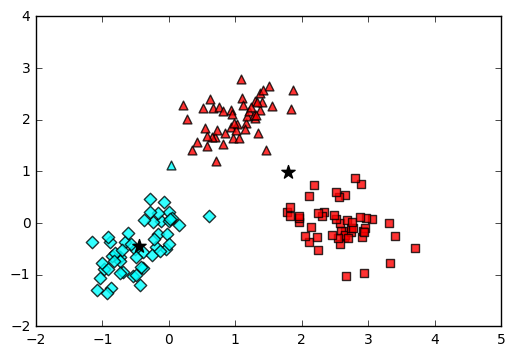

Evaluation for Dataset dataset1.txt, k = 3
SSE:	 49.69882262882385
NMI:	 1.0
SC:	 0.722205425437
CH:	 599.538582562



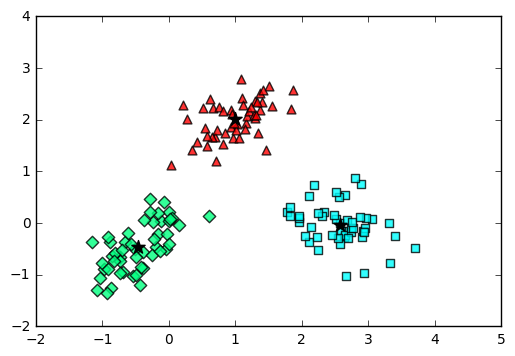

Evaluation for Dataset dataset1.txt, k = 4
SSE:	 38.11336327097853
NMI:	 0.886111348472
SC:	 0.632677714745
CH:	 532.436242072



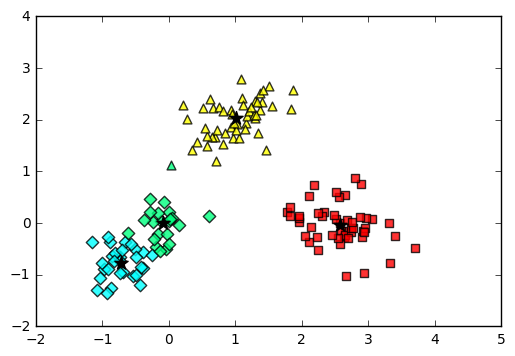

Evaluation for Dataset dataset1.txt, k = 5
SSE:	 31.059717813725644
NMI:	 0.818583834797
SC:	 0.517864119022
CH:	 494.890267219



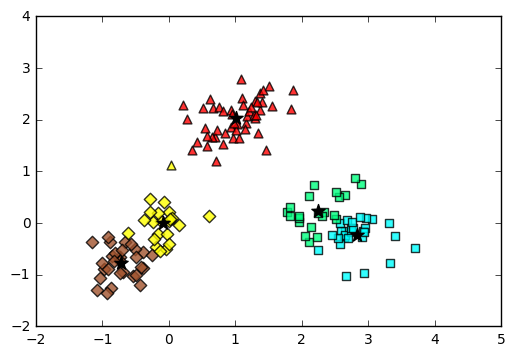

SSE for Dataset:  dataset1.txt


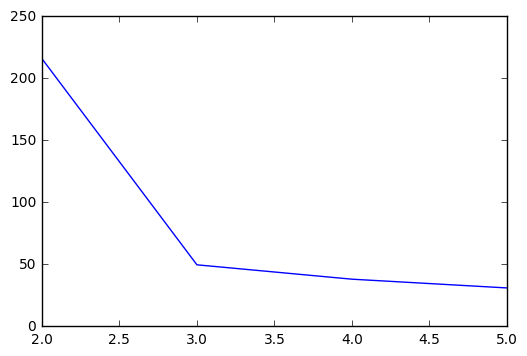

NMI for Dataset:  dataset1.txt


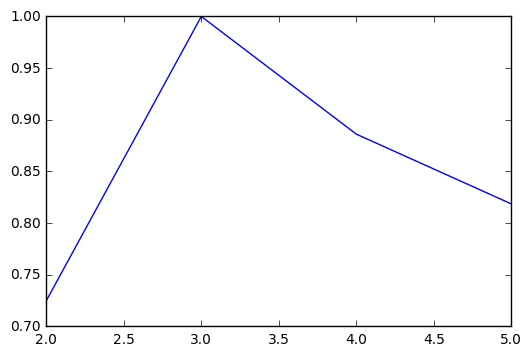

SC for Dataset:  dataset1.txt


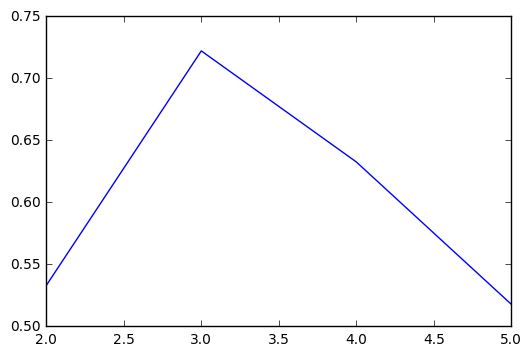

CH for Dataset:  dataset1.txt


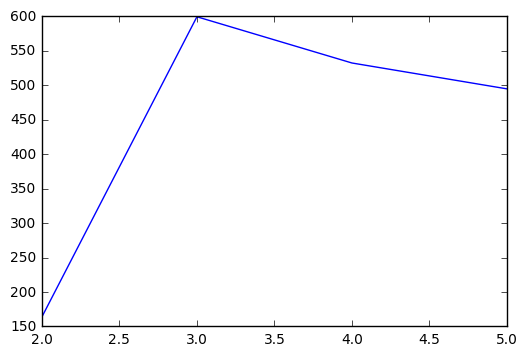

In [18]:
KMeans('dataset1.txt',[2,3,4,5],None)

# KMeans for Dataset 2
### Center of each cluster is Black star

Evaluation for Dataset dataset2.txt, k = 2
SSE:	 476.7089216199835
NMI:	 0.736845537242
SC:	 0.607342795355
CH:	 439.533041472



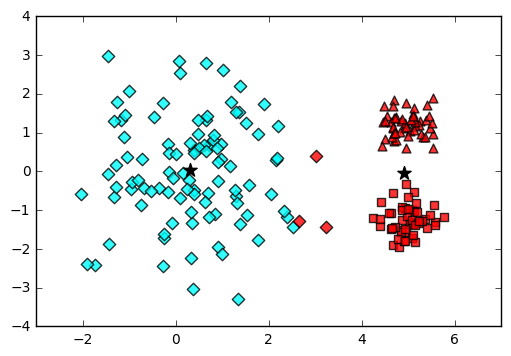

Evaluation for Dataset dataset2.txt, k = 3
SSE:	 319.77456030203626
NMI:	 0.900913051229
SC:	 0.616990882012
CH:	 374.306139722



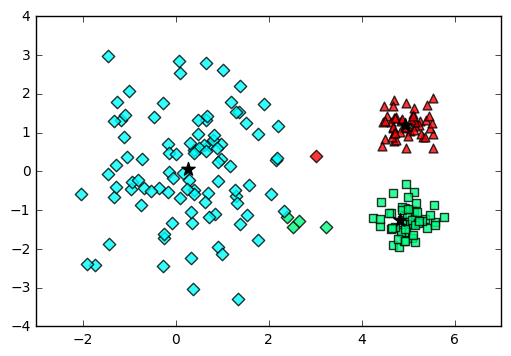

Evaluation for Dataset dataset2.txt, k = 4
SSE:	 204.96433985026823
NMI:	 0.810548975783
SC:	 0.54175899764
CH:	 423.935211744



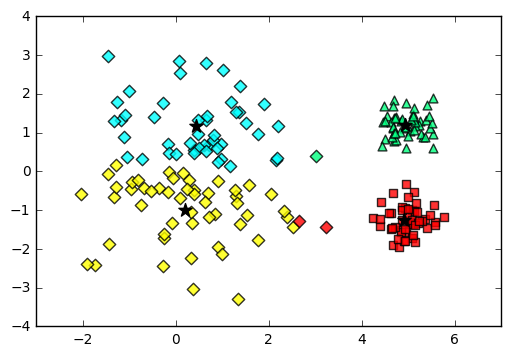

Evaluation for Dataset dataset2.txt, k = 5
SSE:	 152.0469620178433
NMI:	 0.773527284394
SC:	 0.544990446293
CH:	 443.388861671



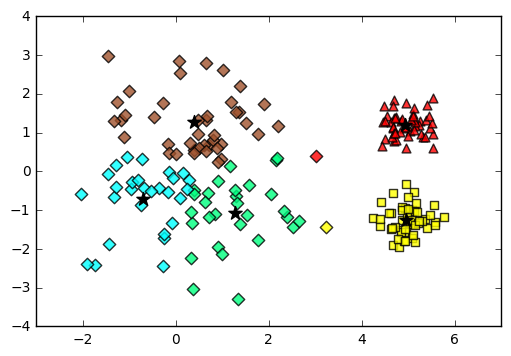

SSE for Dataset:  dataset2.txt


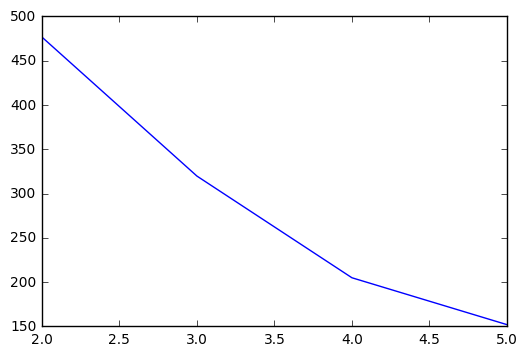

NMI for Dataset:  dataset2.txt


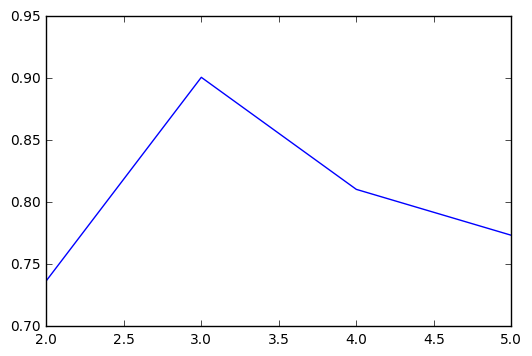

SC for Dataset:  dataset2.txt


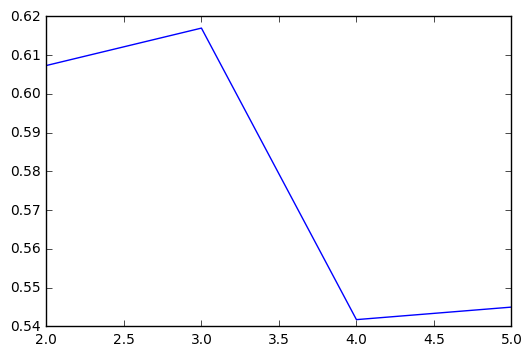

CH for Dataset:  dataset2.txt


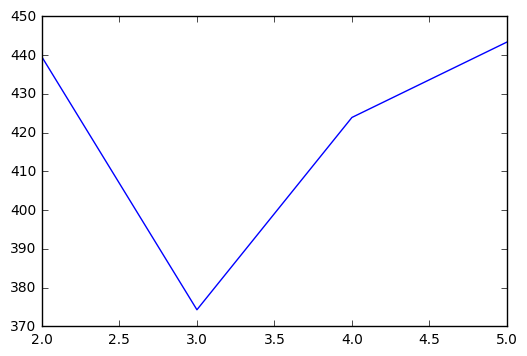

In [19]:
KMeans('dataset2.txt',[2,3,4,5],None)

# KMeans for Dataset 3
### Center of each cluster is Black star

Evaluation for Dataset dataset3.txt, k = 2
SSE:	 76.72624128282992
NMI:	 0.239999049365
SC:	 0.509353694689
CH:	 335.787217054



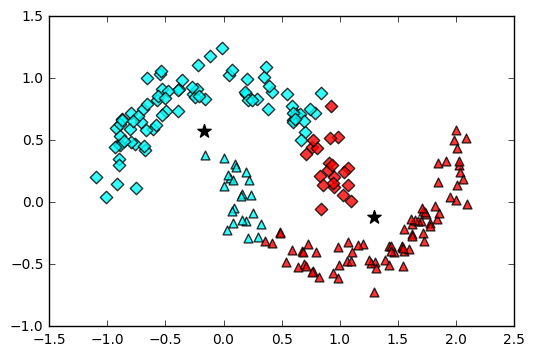

Evaluation for Dataset dataset3.txt, k = 3
SSE:	 47.17707503406801
NMI:	 0.415506783166
SC:	 0.467488155097
CH:	 333.369089881



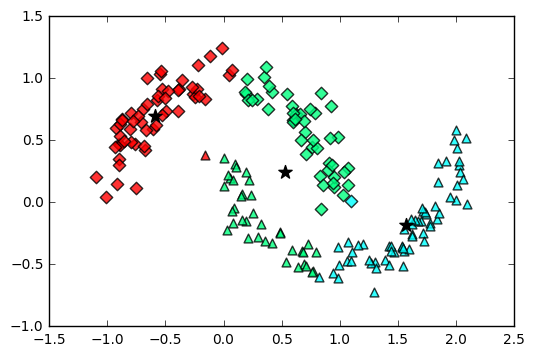

Evaluation for Dataset dataset3.txt, k = 4
SSE:	 32.48333361975078
NMI:	 0.41249754039
SC:	 0.468915311194
CH:	 350.693292279



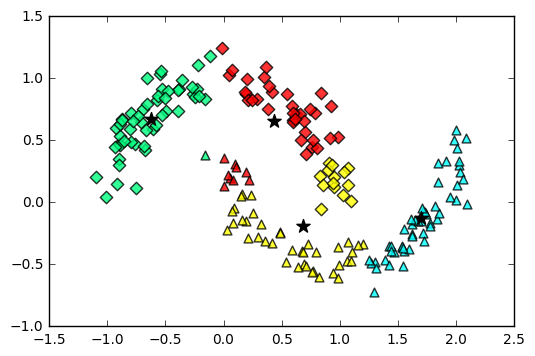

Evaluation for Dataset dataset3.txt, k = 5
SSE:	 24.01291248997887
NMI:	 0.536227107301
SC:	 0.489515210521
CH:	 371.179789309



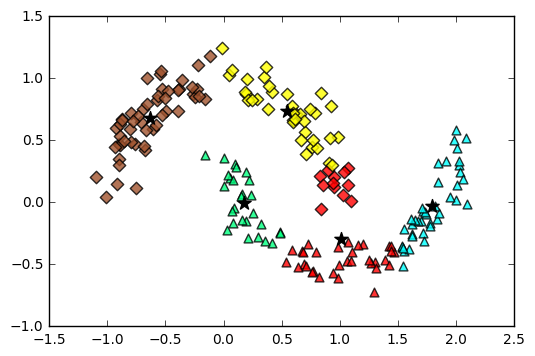

SSE for Dataset:  dataset3.txt


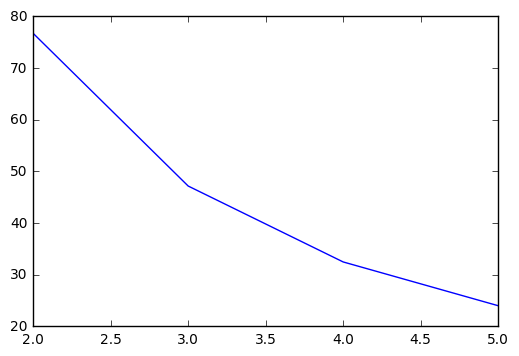

NMI for Dataset:  dataset3.txt


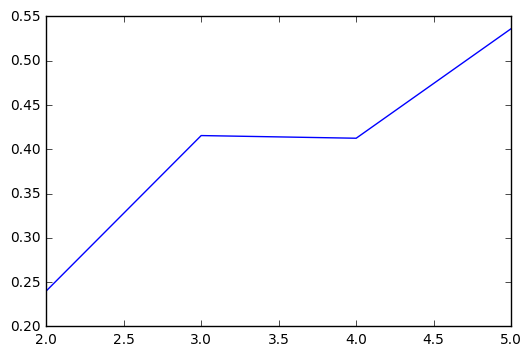

SC for Dataset:  dataset3.txt


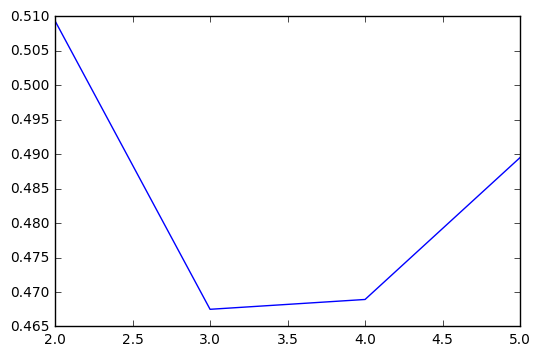

CH for Dataset:  dataset3.txt


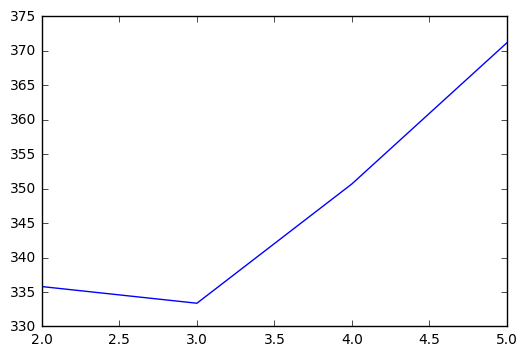

In [20]:
KMeans('dataset3.txt',[2,3,4,5],None)